## Is it a bird?

In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from fastai.vision.widgets import *
from time import sleep


In [2]:
searches = 'grizzly','black', 'teddy'
path = Path('bears')

In [3]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

# import socket,warnings
# try:
#     socket.setdefaulttimeout(1)
#     socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
# except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [4]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
# import os
# iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# if iskaggle:
#     !pip install -Uqq fastai duckduckgo_search

In [5]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [6]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('grizzly bear photos', max_images=1)
urls[0]

Searching for 'grizzly bear photos'


'https://www.goodfreephotos.com/albums/animals/mammals/grizzly-bear-in-the-wild.jpg'

...and then download a URL and take a look at it:

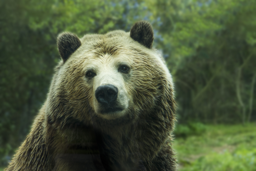

In [7]:
dest = 'bear_grizzly.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'back bear photos'


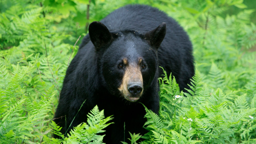

In [8]:
download_url(search_images('back bear photos', max_images=1)[0], 'bear_black.jpg', show_progress=False)
Image.open('bear_black.jpg').to_thumb(256,256)

Searching for 'teddy bear photos'


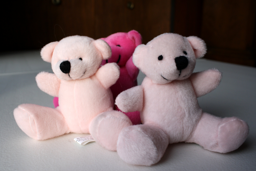

In [9]:
download_url(search_images('teddy bear photos', max_images=1)[0], 'bear_teddy.jpg', show_progress=False)
Image.open('bear_teddy.jpg').to_thumb(256,256)

In [10]:
# for o in searches:
#     dest = (path/o)
#     dest.mkdir(exist_ok=True, parents=True)
#     download_images(dest, urls=search_images(f'{o} bear photo'))
#     sleep(10)  # Pause between searches to avoid over-loading server
#     #download_images(dest, urls=search_images(f'{o} bear photo'))
#     #sleep(10)
#     #download_images(dest, urls=search_images(f'{o} shade photo'))
#     #sleep(10)
#     resize_images(path/o, max_size=400, dest=path/o)

## Step 2: Train our model

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

In [12]:
def guess_bear(x): return x[0].isupper()

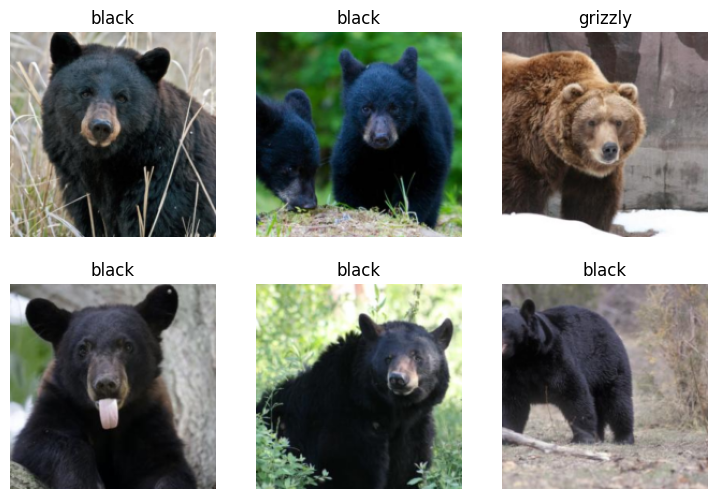

In [13]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='RandomResizedCrop')]
).dataloaders(path, bs=32)


# dsl = ImageDataLoaders.from_name_func('.',
#                                       get_image_files(path),
#                                       valid_pct=0.2, seed=42,
#                                       label_func=guess_bear,
#                                       items_tfms=[Resize(192, method='RandomResizedCrop')])

dls.show_batch(max_n=6)

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [14]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.remove_cb(ProgressCallback)


/home/scopinho/github/DeepLearning/Fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/scopinho/github/DeepLearning/Fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
learn.fine_tune(4)

[0, 2.1317811012268066, 3.6868739128112793, 0.5, '00:03']
[0, 1.8583488464355469, 2.6854121685028076, 0.5, '00:01']
[1, 1.547471284866333, 1.2736810445785522, 0.5, '00:01']
[2, 1.2239660024642944, 0.4823082983493805, 0.14285707473754883, '00:01']
[3, 0.9509918093681335, 0.22678422927856445, 0.14285707473754883, '00:02']


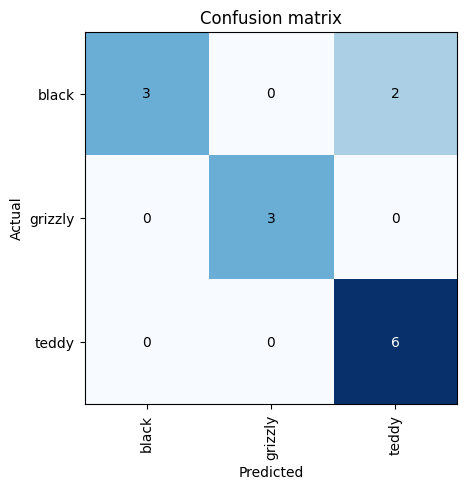

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

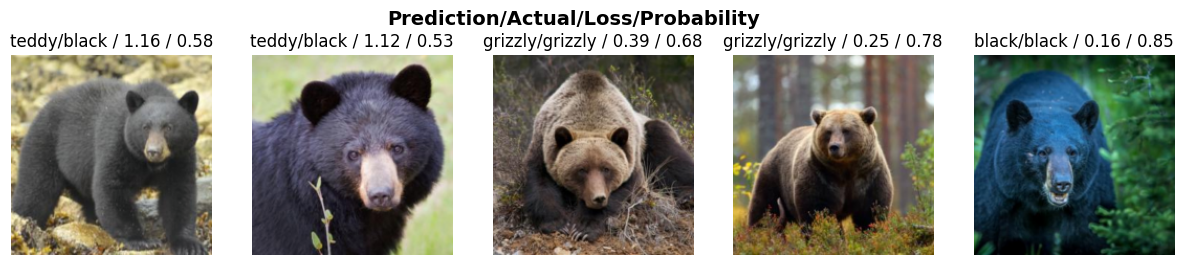

In [17]:
interp.plot_top_losses(5, nrows=1)

In [16]:
#cleaner =  ImageClassifierCleaner(learn)
#cleaner

In [18]:
learn.export('class_bears.pkl')



## Step 3: Use our model (and build your own!)

In [19]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('class_bears.pkl')]

In [20]:
learn_inf = load_learner(path/'class_bears.pkl')

In [22]:
learn_inf.predict('grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([0.0075, 0.9764, 0.0161]))

In [33]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']